Resource:
Chapter 10 and 11 from "Deep Learning with Python" (2nd edition), by Francois Chollet 

* Ch. 10: Deep Learning for time series
* Ch. 11: Deep Learning for text

Note: first and second edition books have slightly different contents about RNNs. 

Examples of timeseries data:  daily price of a stock, the hourly electricity consumption of a city, the evolution of fish populations in a river, or the weather at a location, country’s GDP, or credit card transactions.

The most common timeseries-related task is **forecasting**: predicting what will happen next in a series. Ex: Forecast electricity consumption a few hours in advance so you can anticipate demand. Ch 10 focuses on forecasting. We will learn about recurrent neural networks (RNNs) and how to apply them to timeseries forecasting.

**Temperature forecasting example**

In [1]:
import os # default module
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd  
import seaborn as sns ## this is like ggplot in R

from tensorflow import keras
from keras import layers

In [2]:
os.getcwd()

'c:\\Users\\tpr16\\OneDrive - The Pennsylvania State University\\QunhuaLi__Project\\VS_codes\\hello_ds\\text_data_models'

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv") # path to data
fname  

'jena_climate_2009_2016.csv'

In [4]:
with open(fname) as f:
    data = f.read()   # open and read file

type(data) # string file

str

In [5]:
lines = data.split("\n") # .split will split the string in object "data" into a list. Split occurs everytime new line is observed (i.e. \n)
type(lines) # list  object

list

In [6]:
lines[0] # contains all column names

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"'

In [9]:
header = lines[0].split(",")
header # list of column names

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [10]:
lines = lines[1:]  # list of rows in data
lines[0] # 1st row of the object "data"

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

Each line/row is a timestep: a record of a date and 14 weather-related values.

The dataset has 420,450 rows/lines/timestamps

In [11]:
len(lines)

420451

Converting data into numpy arrays

**Aim**: To predict temperature using 14 predictors like pressure, humidity etc. Data from 2009 to 2016 is considered

14 different quantities were recorded every 10 minutes over several years. (144 measurements per day)

In [12]:
# to store response
temperature = np.zeros((len(lines),)) # np array with 420,450 rows and any number of columns (ncol not specified) 
time_stamps = np.zeros((len(lines),))

# to store predictors
raw_data = np.zeros((len(lines), len(header) - 1)) #nrows = 420,450; #ncol = 14 (exclude the date and time variable)

Below example shows what enumerate function outputs. This is used to create our np arrays: temperature and raw_data

In [13]:
example = ['apple', 'mango', 'banana'] # list
type(example)
print(list(enumerate(example)))
type(enumerate(example))

[(0, 'apple'), (1, 'mango'), (2, 'banana')]


enumerate

In [14]:
# .split and enumerate helped us avoid 3 loops i.e. allow faster computation
# benefit of python: dynamic lists

for i, line in enumerate(lines): # i = iteration number, line = list (in object "lines") corresponding to i-th iteration
    # list comprehension used to define "values" object
    # here enumeration starts from 1 i.e. we omit 0-th column (Date Time column)
    values = [float(x) for x in line.split(",")[1:]] # {float(X) | x \in list_of_row_elements } 
    temperature[i] = values[1]  # response vector                    
    raw_data[i, :] = values[:]  # reponse and 14 predictors 

In [16]:
print(raw_data.shape) # (nrows, ncols)
len(raw_data) # nrows

(420451, 14)


420451

CHECK

In [14]:
# creating list of all time stamps
#for i, line in enumerate(lines):
#    time = [str(x) for x in line.split(" ")[0]]
#    time_stamps[i] = time[0]
#
#time_stamps[0:4]

Plotting temperature time series

Local and global periodicity exists. However, global periodicity is more clear. Locally, there is more chaos.

Text(0, 0.5, 'Temperature (Celsius)')

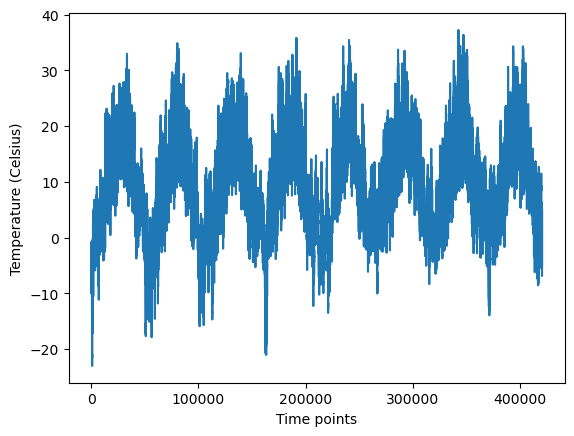

In [17]:
plt.plot(range(len(temperature)), temperature)
plt.xlabel("Time points")
plt.ylabel("Temperature (Celsius)")

Zoomed in plot: Plotting only 10 days (144 measurements per day)

Text(0, 0.5, 'Temperature (Celsius)')

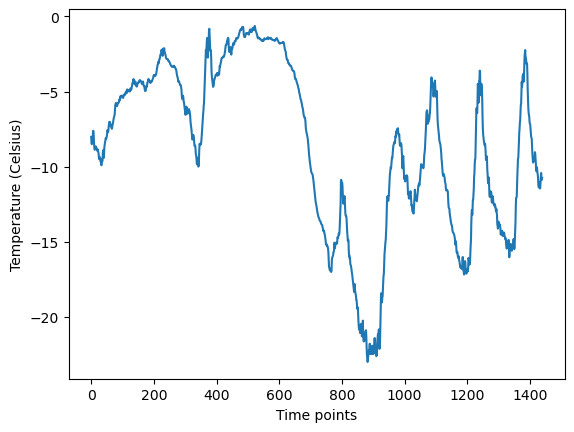

In [18]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel("Time points")
plt.ylabel("Temperature (Celsius)")

* Predicting avg temp for next month, given avg temp of previous months - easier since more periodic
* data over a scale of days, the temperature looks a lot more chaotic. Predicting temperature tomorrow given past - more difficult problem

First 50% data is for training, next 25% for validationand final 25% for testing

**Note**: Here we do not randomly sample data to belong tp test, train, val since time sequence is important. (i.e. test must be most recent events because we want to predict the future)

In case of time series data, val and test sets should be more recent than training data.

In [19]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [20]:
raw_data[:3]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02]])

In [21]:
header[1:]

['"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

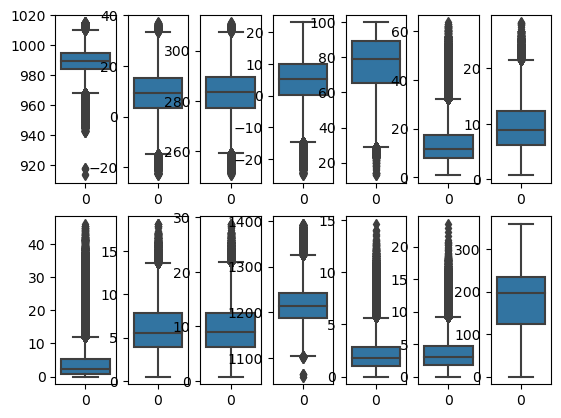

In [22]:
raw_data_df = pd.DataFrame(raw_data, columns=header[1:])

n_rows = 2
n_cols = 7
count = 0
col_num = 0

# seaborn facet grid

plt.subplots(n_rows, n_cols)
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, count+1)
        sns.boxplot(raw_data_df.iloc[:, col_num], orient='vertical')
        if col_num < raw_data_df.shape[1] :
            count += 1
            col_num += 1

plt.show()

In [23]:
raw_data_df.head() # includes both the response (1st col i.e. T(degC)) and the predictors

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)"""
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


**Question of interest**: Given data covering the previous five days and sampled once per hour (Sample 120 data points from 720 data points total data points), can we predict the temperature after 24 hours?

In [24]:
# raw_data[i] gives a 1D array (i-th row)
# normalize data 

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

print("mean tensor:", mean.shape)
print("std tensor:", std.shape)
mean

mean tensor: (14,)
std tensor: (14,)


array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

### Example to understand `timeseries_dataset_from_array()`

* We want batches of data from the past five days (predictors) along with a target temperature (i.e. response) 24 hours in the future.

* `timeseries_dataset_from_array()` gives you windows extracted from the original timeseries (we’ll call them “sequences”).

* For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then `timeseries_dataset_from_array()` will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

* You can also pass a targets argument (an array) to `timeseries_dataset_ from_array()`.

In [22]:
#int_sequence = np.arange(10) # array from 0 to 9
#dummy_dataset = keras.utils.timeseries_dataset_from_array(

#    # The sequences we generate will be sampled from [0 1 2 3 4 5 6] i.e. all except last three
#    data=int_sequence[:-3],    

    # The target for the sequence that starts at data[N] will be data[N + 3]  i.e. offset by 3                           
#    targets=int_sequence[3:],   

    # The sequences will be 3 steps long                            
#    sequence_length=3,    

    # The sequences will be drawn in batches of size 2                                  
#    batch_size=2,                                           
#)

#for inputs, targets in dummy_dataset:
#    for i in range(inputs.shape[0]):
#        print([int(x) for x in inputs[i]], int(targets[i]))

In [23]:
#list(dummy_dataset) # here we see that batch size = 2

For our current temperature forecast example, we will use following parameter values:

* `sampling_rate = 6`—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
* `sequence_length` = 120—Observations will go back 5 days (120 hours).
* `delay` = $$\text{sampling\_ rate} * (\text{sequence\_ length} + 24 - 1)$$ —The target for a sequence will be the temperature 24 hours after the end of the sequence.
* When making the training dataset, we’ll pass `start_index = 0` and `end_index = num_train_samples` to only use the first 50% of the data. For the validation dataset, we’ll pass `start_index = num_train_samples` and `end_index = num_train_samples + num_val_samples` to use the next 25% of the data. Similarly test dataset

**About code**: Note that we need to sample the first 120 predictors from the first 120x6 data points for each time series variable present in raw data. We want to predict the temperature 24 hours later i.e. (24-1)x6 data points further away.

In [25]:
# sample one data per hour (6 measurements per hour i.e. 1 measurement per 10 min)
sampling_rate = 6 

# draw sequences (predictors) of length 120
sequence_length = 120 

# amount offset needed to generate target sequence i.e. where is our first target/response value
delay = sampling_rate * (sequence_length + 24 - 1)

batch_size = 256 


train_dataset = keras.utils.timeseries_dataset_from_array(

    # where to draw samples from 
    raw_data[:-delay],

    # first target location
    targets=temperature[delay:],

    # at what rate to sample points from raw_data
    sampling_rate=sampling_rate,

    # what length of sequences to sample
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,

    # do the operation only on the training set which starts at 0-th row and ends at 'num_train_samples' row
    start_index=0,
    end_index=num_train_samples)



val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)


test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [26]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


### Understanding `train_dataset` structure:
We see from the code below that `train_dataset` has two parts: a tensor of shape $256 \times 120 \times 14$ and another tensor of size 256. 256 here denotes the `batch_size` i.e. in the code below, we have processed a batch of $256$ input-output pairs. Here, input would imply the $120$ temperature observations from the past while output is the average temperature 24 hours later (i.e. in the future.)

In [27]:
# "samples" object loops over each batch of 256 input-output pairs
# "targets" object loops over the response variable (i.e. temperature 24 hrs later)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [28]:
# there are 819 batches of 256 input output pairs 
print(len(list(train_dataset)))

819


In [29]:
# train_dataset can be viewed as list of tensors of size . Each element of the list corresponds to a batch of 256 input-output pairs.
# each 120x14 matrix is one input-output pairing. We process 256 such batches at once
print(list(train_dataset)[0]) 

(<tf.Tensor: shape=(256, 120, 14), dtype=float64, numpy=
array([[[ 0.91129998,  0.38240827,  0.30735954, ..., -0.13026616,
         -0.24126854,  0.83819695],
        [ 1.00300957,  0.29005831,  0.20809953, ...,  0.06535352,
          0.51204955,  1.07349019],
        [ 0.99713075,  0.50440143,  0.42128296, ...,  0.33922107,
          0.46039345,  0.95351393],
        ...,
        [ 0.00948904,  1.40851896,  1.39696374, ...,  0.48267551,
          1.15775077,  2.13114494],
        [-0.04106881,  1.48034671,  1.4725367 , ...,  0.47615485,
          0.61966642, -1.87978941],
        [-0.10573582,  1.55103433,  1.54810966, ...,  0.80218765,
          1.10609467,  1.30412415]],

       [[ 0.6855533 , -1.50221502, -1.54248609, ...,  0.13708074,
          0.35277658, -0.30448952],
        [ 0.63381969, -1.57518289, -1.61016337, ...,  0.03275024,
          0.24515971, -0.15655764],
        [ 0.56327386, -1.59798535, -1.62821064, ...,  0.03275024,
         -0.13365167, -0.04589992],
        ..

In [30]:
# training response tensor
print(list(train_dataset)[0][1])

tf.Tensor(
[ 1.575e+01 -2.800e-01  1.086e+01  3.600e-01  6.490e+00  2.191e+01
 -1.332e+01 -1.126e+01 -4.970e+00  8.240e+00  1.950e+01  1.430e+00
 -1.780e+00  5.500e+00 -4.480e+00  1.915e+01  2.163e+01  4.200e+00
 -7.460e+00  9.100e+00  1.853e+01  1.800e+01  1.976e+01  1.681e+01
  3.700e-01  1.320e+01  1.169e+01  1.182e+01  6.840e+00  1.089e+01
  9.320e+00  1.136e+01  9.720e+00  1.009e+01  7.140e+00  8.650e+00
  1.074e+01  1.444e+01  1.804e+01  9.790e+00 -6.520e+00  1.958e+01
  1.827e+01  1.163e+01  4.690e+00  3.220e+00  1.655e+01  2.656e+01
 -1.260e+00  1.049e+01 -6.530e+00  1.667e+01 -6.000e-02  1.500e+00
  2.359e+01  2.569e+01  1.124e+01  1.508e+01  3.970e+00 -6.290e+00
 -3.300e-01  8.190e+00  7.190e+00  1.697e+01 -3.790e+00  1.910e+01
  1.089e+01  1.014e+01  4.300e+00  8.830e+00  1.994e+01  5.740e+00
  2.145e+01  1.946e+01  1.496e+01 -3.090e+00  1.570e+00  6.450e+00
 -8.640e+00 -9.600e+00  4.300e-01  9.770e+00  1.157e+01  1.146e+01
  1.016e+01  8.240e+00 -1.124e+01  2.034e+01 -1.630

In [31]:
# first sequence of 120 predictors sampled at rate 1 per hour.
print(list(train_dataset)[0][0][0])

tf.Tensor(
[[-0.83000641 -1.62990879 -1.55602154 ...  1.87157524  2.03590443
  -1.85532823]
 [-0.85234592 -1.62078781 -1.54586995 ...  1.63031097  1.65709305
  -1.85311507]
 [-0.81942453 -1.6401699  -1.56730109 ...  1.94330246  1.79484264
  -1.82073313]
 ...
 [-1.15216572 -1.43608788 -1.3383263  ...  0.24793189  0.14184752
  -0.05521847]
 [-1.17332947 -1.38592247 -1.28756834 ...  0.27401451  0.03853532
  -0.43378432]
 [-1.22036003 -1.30611386 -1.20409969 ... -0.01289435 -0.08630025
  -0.10996491]], shape=(120, 14), dtype=float64)


### Baseline approach

We should establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such "simple baselines" can be useful when you’re approaching a new problem for which there is no known solution (yet).

**Example of a simple baseline**: Consider unbalanced classification task where 90% data belongs to class A while the rest belongs to class B. So a "classifier" that always predicts A is already 90% accurate. We need to do better than that in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

The baseline we will use: predict that the temperature 24 hours from now will be equal to the temperature right now. 

In [32]:
# define a function "evaluate_naive_method"

def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:

        # as seen in line 36, samples loops over tensors of size (256, 120, 14).
        # so "samples[:, -1, 1]" means consider all 256 batches, ignore the last column (i.e. last input temp measurement)
        preds = samples[:, -1, 1] * std[1] + mean[1]         
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
  
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


We observe that baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. 

## Callbacks and TensorBoard
When you’re training a model, you can’t tell how many epochs will be needed to get to an optimal validation loss. Our examples so far have adopted the strategy of training for enough epochs that you begin overfitting, using the first run to figure out the proper number of epochs to train for, and then finally launching a new training run from scratch using this optimal number. Of course, this approach is wasteful. A much better way to handle this can be done by using **callback**.

Callbacks are passed to the model via the callbacks argument in `fit()`, which takes a list of callbacks. You can pass any number of callbacks and write your own callbacks. *Some examples* of callbacks:
* `keras.callbacks.EarlyStopping` : interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs.  
* `keras.callbacks.ModelCheckpoint` : lets you continually save the model during training (and, optionally, save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch).
* `keras.callbacks.LearningRateScheduler` : Dynamically adjusting learning rate parameter of the optimizer.
* We can also write our own callbacks.

Below is code to understand how callbacks are passed into the `fit()` function.

In [69]:
# define all the callbacks
# this list will be passed to the fit() function

from keras.datasets import mnist

# Load the mnist data
(images, labels), (test_images, test_labels) = mnist.load_data()      
images = images.reshape((60000, 28 * 28)).astype("float32") / 255 
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255 
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]


# create list of desired callbacks, can pass any num. of callbacks
callbacks_list = [                                     
    keras.callbacks.EarlyStopping(      #  to interrupt training when "improvement" stops              
        monitor="val_accuracy",         #  "improvement" measured using mentioned metric          
        patience=2,                     #  "improvement" is said to stop when metric of interest has stopped improving for two epochs             
    ),
    keras.callbacks.ModelCheckpoint(           # saves current weights after every epoch        
        filepath="checkpoint_path.keras",      # file to dynamicaly save best model      
        monitor="val_loss",                    # "best" model is one with least val_loss      
        save_best_only=True,                   # won’t overwrite the model file unless val_loss has improved      
    )
]


# define the model for mnist data
def get_mnist_model():                                                
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

model = get_mnist_model()

# compile the model
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


# pass the callbacks list to the fit function
model.fit(train_images, train_labels,                  
          epochs=10,                                   
          callbacks=callbacks_list,                    
          validation_data=(val_images, val_labels)) 


Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2940 - accuracy: 0.9119 - val_loss: 0.1434 - val_accuracy: 0.9576
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1644 - accuracy: 0.9530 - val_loss: 0.1163 - val_accuracy: 0.9682
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1387 - accuracy: 0.9624 - val_loss: 0.1051 - val_accuracy: 0.9725
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1251 - accuracy: 0.9670 - val_loss: 0.1059 - val_accuracy: 0.9732
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1177 - accuracy: 0.9705 - val_loss: 0.1143 - val_accuracy: 0.9757
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1118 - accuracy: 0.9725 - val_loss: 0.1045 - val_accuracy: 0.9769
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1062 - accuracy: 0.9751 - val_loss: 0.1059 - val_accuracy:

![](./pictures/tensorboard.png)

### TensorBoard

Before proceeding further, we need to understand TensorBoard. TensorBoard (www.tensorflow.org/tensorboard) is a browser-based application that you can run locally. It’s the best way to monitor everything that goes on inside your model during training. With TensorBoard, you can:
* Visually monitor metrics during training
* Visualize your model architecture
* Visualize histograms of activations and gradients
* Explore embeddings in 3D

The easiest way to use TensorBoard with a Keras model and the `fit()` method is to use the `keras.callbacks.TensorBoard` callback.

Reference: https://www.tensorflow.org/tensorboard/get_started

In [70]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# define the tensorboard callback
tensorboard = keras.callbacks.TensorBoard(
    log_dir="./logs/",
)

model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2937 - accuracy: 0.9136 - val_loss: 0.1385 - val_accuracy: 0.9603
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1635 - accuracy: 0.9536 - val_loss: 0.1224 - val_accuracy: 0.9688
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1390 - accuracy: 0.9630 - val_loss: 0.1177 - val_accuracy: 0.9708
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1288 - accuracy: 0.9676 - val_loss: 0.1114 - val_accuracy: 0.9722
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1152 - accuracy: 0.9711 - val_loss: 0.1114 - val_accuracy: 0.9758
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1091 - accuracy: 0.9736 - val_loss: 0.1234 - val_accuracy: 0.9756
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1031 - accuracy: 0.9750 - val_loss: 0.1191 - val_accuracy:

## Trying basic machine learning models

### 1. Feed-forward network

In the same way that it’s useful to establish a basic baseline before trying machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to *make sure any further complexity you throw at the problem is legitimate and delivers real benefits*.

We will now try some basic models. Our final goal is to get a model that performs much better than the baseline. Two basic models: feed forward neural network and 1D ConvNet

In [33]:
# basic fully/densely connected feed-forward neural network
# written in functional API form, not sequential model format

# sequence_length = 120 (num. of measurements per used from past to predict future)
# raw_data.shape[-1] = 14 i.e. num. of variables (response + predictors)
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) 

# flatten the input tensor
x = layers.Flatten()(inputs)

# one hidden layer with 16 hidden units and ReLu activation
x = layers.Dense(16, activation="relu")(x)

# output layer, no activation used (default)
outputs = layers.Dense(1)(x)

# model the input-output as mentioned
model = keras.Model(inputs, outputs)

In [41]:
# define callbacks
# if save_best_only=True, it only saves when the model is considered the "best" according to the quantity monitored (default is False)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
] 


# Compile model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 11s 12ms/step - loss: 6.6209 - mae: 2.0351 - val_loss: 12.1037 - val_mae: 2.7501
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 6.5133 - mae: 2.0179 - val_loss: 11.5010 - val_mae: 2.6732
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 6.4321 - mae: 2.0072 - val_loss: 12.4316 - val_mae: 2.7774
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 6.3762 - mae: 1.9975 - val_loss: 11.8343 - val_mae: 2.7247
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 6.3246 - mae: 1.9895 - val_loss: 11.8794 - val_mae: 2.7060
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 6.2540 - mae: 1.9780 - val_loss: 12.5062 - val_mae: 2.8035
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 6.2014 - mae: 1.9707 - val_loss: 11.8995 - val_mae: 2.7243
Epoch 8/10
819/819 [==============================] - 1

In [42]:
# save "best" model according to metric being monitered
model = keras.models.load_model("jena_dense.keras")  

# use python f-strings to print. hHere, f stands for format
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") 

405/405 [==============================] - 4s 8ms/step - loss: 12.3338 - mae: 2.7783
Test MAE: 2.78


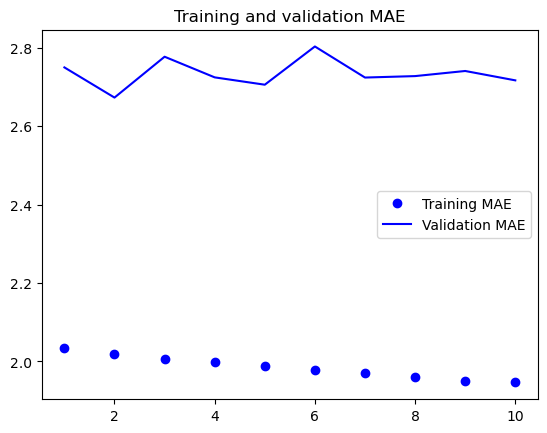

In [45]:
# displaying the loss curves for validation and training sets

# stores training mae over 10 epochs
loss = history.history["mae"] 

# stores val mae over 10 epochs
val_loss = history.history["val_mae"] 

# len(loss) = 10 i.e. num. of epochs
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The test and validation MAE were 2.6 and 2.4 approximately for the naive method we used earlier. Using a dense network doesn't seem to perform significantly better than the naive method we introduced. This shows the use of our baseline. Although no learning was used, our naive method does incorporate some useful information. Probably because architecture doesn't have enough capacity or the stochastic gradient descent didn't reach the required minima.

* The densely connected approach first flattened the timeseries, which removed the notion of time from the input data.

## 2. 1D ConvNet

Reference: https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610#:~:text=1D%20CNN%20can%20perform%20activity,the%20acceleration%20in%203%20axes.

1D, 2D, 3D convnet depends on whether the kernel has to be slided in a 1D, 2D or 3D fashion. CNNs in general, are useful in scenarios where we want to finad local spatial patterns. 

You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data (text data and time series data) that follows the **translation invariance assumption** (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

![](2Dcnn.png) ![](1dcnn.png) ![](1d.png) 

Initial window length = 24, so that we look at 24 hours of data at a time (one cycle).

In [46]:
# input is 120x14 i.e. 120 past measurements over all 14 variables
# time series data along the columns
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 8 filters, each filter is 24x14 (enough to inpt 24)
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)

#for each feature dimension, it takes average among all time steps.
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 58s 69ms/step - loss: 22.3509 - mae: 3.6951 - val_loss: 15.7666 - val_mae: 3.1678
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 15.8924 - mae: 3.1589 - val_loss: 15.8425 - val_mae: 3.1397
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 14.7170 - mae: 3.0377 - val_loss: 15.7605 - val_mae: 3.1319
Epoch 4/10
819/819 [==============================] - 55s 66ms/step - loss: 14.0032 - mae: 2.9647 - val_loss: 17.5777 - val_mae: 3.3402
Epoch 5/10
819/819 [==============================] - 58s 70ms/step - loss: 13.4058 - mae: 2.8945 - val_loss: 15.6207 - val_mae: 3.1371
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 12.8099 - mae: 2.8255 - val_loss: 16.6580 - val_mae: 3.1959
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 12.3390 - mae: 2.7727 - val_loss: 15.6042 - val_mae: 3.0884
Epoch 8/10
819/819 [============================

In [47]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 16.8470 - mae: 3.2283
Test MAE: 3.23


Test MAE is 3.23 which is worse than both feed-forward NN test MAE and naive model Test MAE. Possible reasons:
* First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
* Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information. 

## Simple LSTM model

![](./pictures/lstm.png) 

* In the below code, the LSTM cell is unrolled `sequence_length` times and each $x_t$ is a 14-dimensional vector.
* `return_sequences` controls whether all time-step output need to be returned or only the last time step needs to be returned.
* Default: `return_sequences = False` i.e. only  last time step returned.

In [59]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [60]:
outputs.shape

TensorShape([None, 1])

In [61]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 53s 61ms/step - loss: 41.6712 - mae: 4.6924 - val_loss: 12.4046 - val_mae: 2.6826
Epoch 2/10
819/819 [==============================] - 59s 72ms/step - loss: 11.1651 - mae: 2.5937 - val_loss: 9.6400 - val_mae: 2.4176
Epoch 3/10
819/819 [==============================] - 74s 90ms/step - loss: 9.7964 - mae: 2.4358 - val_loss: 9.2837 - val_mae: 2.3609
Epoch 4/10
819/819 [==============================] - 76s 93ms/step - loss: 9.2294 - mae: 2.3697 - val_loss: 9.4488 - val_mae: 2.3853
Epoch 5/10
819/819 [==============================] - 77s 93ms/step - loss: 8.9106 - mae: 2.3314 - val_loss: 9.5563 - val_mae: 2.3993
Epoch 6/10
819/819 [==============================] - 83s 101ms/step - loss: 8.6559 - mae: 2.2957 - val_loss: 9.7105 - val_mae: 2.4136
Epoch 7/10
819/819 [==============================] - 84s 102ms/step - loss: 8.4689 - mae: 2.2701 - val_loss: 9.9384 - val_mae: 2.4367
Epoch 8/10
819/819 [==============================] - 77s

In [50]:
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 10s 23ms/step - loss: 10.8086 - mae: 2.5349
Test MAE: 2.53


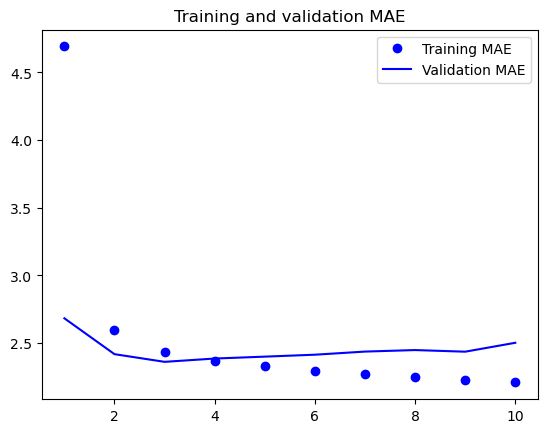

In [62]:
# displaying the loss curves for validation and training sets

# stores training mae over 10 epochs
loss = history.history["mae"] 

# stores val mae over 10 epochs
val_loss = history.history["val_mae"] 

# len(loss) = 10 i.e. num. of epochs
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The LSTM model begins to overfit pretty quickly i.e. after 3rd, 4th epoch itself.

## Simple RNN Architecture

Note that $O_t = Wh_t$ where $h_t = tanh(b + V h_{t-1}+ U x_t)$

![](./pictures/simplernn.png)    ![](./pictures/stack.png) 


In keras module, `SimpleRNN` layer implements the first RNN architecture above (one to the left) except that it assumes $W = I$

* `SimpleRNN` processes batches of sequences. This means it takes inputs for `shape` argument `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.
* We can set the timesteps entry to None (in the shape argument), which enables the network to process sequences of arbitrary length.
* If all of your sequences have the same length, it is recommended to specify a complete input shape, since it enables `model.summary()` to display output length information

In [63]:
num_features = 14 
# any num. of x_t's
inputs = keras.Input(shape=(None, num_features))
# o_t must be 16-dimensional
outputs = layers.SimpleRNN(16)(inputs)

# Note: o_t being 16-dim and x_t being 14-dim is sufficient to uniquely determine all parameter matrix dimensions
outputs.shape

TensorShape([None, 16])

* Each timestep t, the output tensor, $O_t$ contains information about timesteps 0 to t in the input sequence i.e. about the entire past. For this reason, in many cases, you don’t need this full sequence of outputs; you just need the last output.
* All recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape `(batch_size, timesteps, output_features)`) or return only the last output for each input sequence (a rank-2 tensor of shape `(batch_ size, output_features)`). 
* These two modes are controlled by the `return_sequences` argument.
* For `SimpleRNN` , `return_sequences = FALSE` is the default i.e. it only returns output at *last time step*


In the current example, one input sequence = $x_1, x_2, ..., x_{120}$ where each $x_t$ is 14-dim feature vector. Corresponding to each $x_t$, there is a 16-dim $o_t$. If data is being processed in batches of, say $64$, then `return_sequences = False` will return only the $o_{120}$ corresponding to the batch of $64$ inputs. Hence output is a tensor of size $64 \times 16$. On the other hand if we set `return_sequences = True`, then we get $o_t$ corresponding to all 120 time stamps for the batch of 64 inputs. Hence output is $64 \times 120 \times 16$

In [64]:
num_features = 14 
steps = 120 
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)   
print(outputs.shape) # (batch_size, output_features)


num_features = 14 
steps = 120 
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)   
print(outputs.shape) # (batch_size, timesteps, output_features)

(None, 16)
(None, 120, 16)


Stacked RNN layers (again using functional API)

In [65]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

What can we do with recurrent layers in Keras? The following techniques will be used to refine our temperature-forecasting RNN.
* Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
* Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).

### Dropout
![](./pictures/drop.png) 

* Dropout creates ensembles of neural networks with different model configurations to reduce over-fitting.
* Dropout is implemented per-layer in a neural network.
* Dropout may be implemented on any or all hidden layers in the network as well as the visible or input layer. It is not used on the output layer.
* A common value is a probability of 0.5 for retaining the output of each node in a hidden layer and a value close to 1.0, such as 0.8, for retaining inputs

### Recurrent Dropout
* Proper way to use dropout with a recurrent network is to use the same dropout mask (the same pattern of dropped units) at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. 
* Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units.
* Note that networks being regularized with dropout always take much longer to fully converge, so train them larger number of epochs.

## Dropout-regularized LSTM

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)

# 32-dim output nodes from the LSTM is dropped with prob 0.5
x = layers.Dropout(0.5)(x)                             
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)  

Epoch 1/50
819/819 [==============================] - 205s 248ms/step - loss: 30.4011 - mae: 4.0386 - val_loss: 17.0060 - val_mae: 2.8637
Epoch 2/50
819/819 [==============================] - 224s 274ms/step - loss: 14.8374 - mae: 2.9900 - val_loss: 9.5077 - val_mae: 2.3933
Epoch 3/50
819/819 [==============================] - 236s 288ms/step - loss: 14.0652 - mae: 2.9064 - val_loss: 9.5589 - val_mae: 2.3966
Epoch 4/50
819/819 [==============================] - 231s 282ms/step - loss: 13.5230 - mae: 2.8456 - val_loss: 9.5223 - val_mae: 2.3908
Epoch 5/50
819/819 [==============================] - 232s 283ms/step - loss: 13.1551 - mae: 2.8063 - val_loss: 9.5592 - val_mae: 2.3974
Epoch 6/50
819/819 [==============================] - 287s 351ms/step - loss: 12.7236 - mae: 2.7565 - val_loss: 9.4480 - val_mae: 2.3907
Epoch 7/50
819/819 [==============================] - 325s 397ms/step - loss: 12.4722 - mae: 2.7291 - val_loss: 9.3223 - val_mae: 2.3752
Epoch 8/50
819/819 [====================

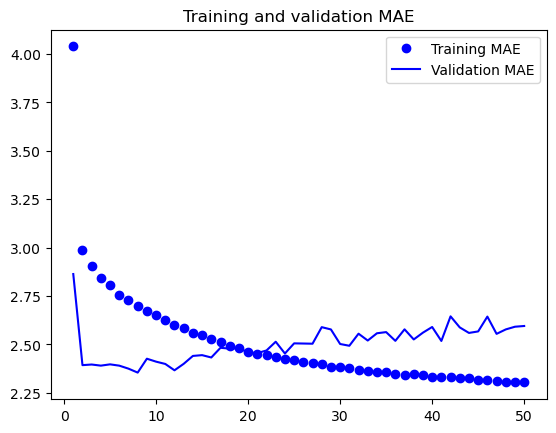

In [49]:
# displaying the loss curves for validation and training sets

# stores training mae over 10 epochs
loss = history.history["mae"] 

# stores val mae over 10 epochs
val_loss = history.history["val_mae"] 

# len(loss) = 10 i.e. num. of epochs
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"]) 


model.fit(train_images, train_labels,                                 
          epochs=3,                                                   
          validation_data=(val_images, val_labels))  

# outputs the loss and metric (accuracy) on new data (test data).
model.evaluate(test_images, test_labels)

# outputs classification probabilities on new data (test data)
model.predict(test_images)